## Import 

In [30]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import plotly.express as px
from pathlib import Path


## Load Data

In [31]:
data_path = Path('../data')
dfs = {f.stem: pd.read_csv(f) for f in data_path.glob('*.csv')}
df_recent = dfs['conso_recent_2026']
df_recent['date_heure'] = pd.to_datetime(df_recent['date_heure'])



 ## EDA + Graph

In [32]:
fig = px.line(df_recent, x='date_heure', y=['consommation', 'prevision_j'])
fig.show()


## ML Pipeline



In [33]:
df_recent['heure'] = df_recent['date_heure'].dt.hour
df_recent['jour'] = df_recent['date_heure'].dt.dayofweek

X = df_recent[['heure', 'jour', 'prevision_j']]
y = df_recent['consommation']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
model = RandomForestRegressor(n_estimators=100)
model.fit(X_train, y_train)

preds = model.predict(X_test)
print(f"MAE: {mean_absolute_error(y_test, preds):.0f} MW")


MAE: 305 MW


## Prédiction future

In [34]:
pred = model.predict([[20, 5, 65000]])[0]
print(f"Prediction 20h Vendredi: {pred:.0f} MW")


Prediction 20h Vendredi: 64443 MW


/Users/bvfode/Desktop/Consomation-electricite-france/venv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning:

X does not have valid feature names, but RandomForestRegressor was fitted with feature names



## Sauvegarde du model 

Modele sauve: models/rte_conso_model.pkl

Feature importance:
       feature  importance
2  prevision_j    0.997001
0        heure    0.002573
1         jour    0.000426


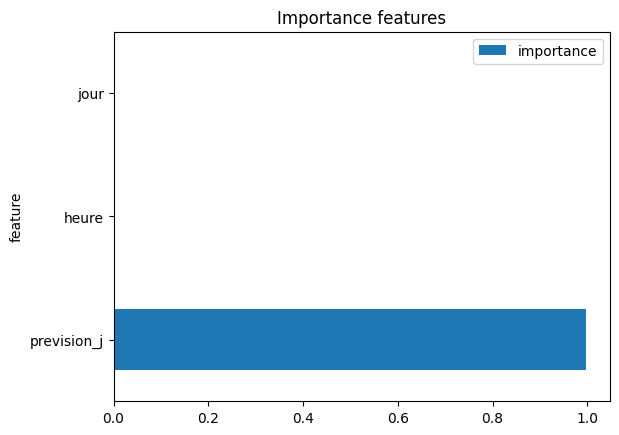

In [35]:
import joblib
import os

# Crée dossier + sauve
os.makedirs('models', exist_ok=True)
joblib.dump(model, 'models/rte_conso_model.pkl')
print("Modele sauve: models/rte_conso_model.pkl")

# Feature importance
importances = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)
print("\nFeature importance:")
print(importances)

importances.plot(kind='barh', x='feature', y='importance')
plt.title('Importance features')
plt.show()


In [37]:
# 1. Vérif exacte .env
from dotenv import load_dotenv
import os
load_dotenv()  # .env maintenant dans /ml/
print(f"ID: '{os.getenv('RTE_CLIENT_ID')}'")  # Exact, espaces?
print(f"Secret: '{os.getenv('RTE_CLIENT_SECRET')[:20]}...'")  # Preview

# 2. Test Basic Auth (souvent requis RTE)
import requests
import base64

client_id = os.getenv('RTE_CLIENT_ID')
client_secret = os.getenv('RTE_CLIENT_SECRET')
creds = base64.b64encode(f"{client_id}:{client_secret}".encode()).decode()
headers = {'Authorization': f'Basic {creds}'}
auth_data = {'grant_type': 'client_credentials'}

resp = requests.post("https://digital.iservices.rte-france.com/token/oauth/", 
                     headers=headers, data=auth_data)
print(f"Basic Auth status: {resp.status_code}")
print(resp.text)


ID: '599a4999-a8c9-45f9-85d8-a0effc0a3cf8'
Secret: '4bd95649-4734-4828-9...'
Basic Auth status: 200
{
  "access_token" : "gb9BrlX1qVOuV1UQXLDO0FuE3kdaGvCz7SrlFV1XccmRd5zQt8jqIi",
  "token_type" : "Bearer",
  "expires_in" : 3600
}


In [38]:
import requests
import pandas as pd
from dotenv import load_dotenv
import os
import base64  # Nécessaire Basic

load_dotenv()  # .env dans /ml/
client_id = os.getenv('RTE_CLIENT_ID')
client_secret = os.getenv('RTE_CLIENT_SECRET')

# Basic Auth (comme votre test)
creds = base64.b64encode(f"{client_id}:{client_secret}".encode()).decode()
auth_headers = {'Authorization': f'Basic {creds}'}
auth_data = {'grant_type': 'client_credentials'}

resp_auth = requests.post("https://digital.iservices.rte-france.com/token/oauth/", 
                          headers=auth_headers, data=auth_data)
token = resp_auth.json()['access_token']
print(f"Token: {len(token)} chars (1h)")

# API Data
start, end = '2024-12-01T00:00:00', '2025-12-15T23:59:00'
url = f"https://digital.iservices.rte-france.com/open_api/consumption/v1/consumption?start_date={start}&end_date={end}"
headers = {'Authorization': f'Bearer {token}'}

resp_data = requests.get(url, headers=headers)
print(f"Data status: {resp_data.status_code}")

if resp_data.status_code == 200:
    df = pd.DataFrame(resp_data.json())
    df['datetime'] = pd.to_datetime(df['updated'])
    df.to_csv('../data/rte_consommation_real.csv', index=False)  # Racine data/
    print(df.head())
    print("🎉 Dataset réel créé ! Prêt Azure/ML")


Token: 54 chars (1h)
Data status: 403
